<a href="https://colab.research.google.com/github/jaranohaal/Fake-news-classification/blob/main/Fake_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a project for fine-tuning DistilBert model for fake news classification task

## Loading necessary libraries

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00


In [2]:
from datasets import list_datasets, load_dataset

In [3]:
import pandas as pd

In [4]:
dataset_list = list_datasets()

<ipython-input-4-064ad6522921>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  dataset_list = list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
target = "GonzaloA/fake_news"
if target in dataset_list:
  print("Target dataset '" + target + "' is found")
else:
  print("Not found")

Target dataset 'GonzaloA/fake_news' is found


In [6]:
dataset = load_dataset(target)

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/24353 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8117 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8117 [00:00<?, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 24353
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 8117
    })
    test: Dataset({
        features: ['Unnamed: 0', 'title', 'text', 'label'],
        num_rows: 8117
    })
})

In [8]:
dataset.column_names

{'train': ['Unnamed: 0', 'title', 'text', 'label'],
 'validation': ['Unnamed: 0', 'title', 'text', 'label'],
 'test': ['Unnamed: 0', 'title', 'text', 'label']}

In [9]:
train = dataset["train"]
test = dataset["test"]

In [10]:
train

Dataset({
    features: ['Unnamed: 0', 'title', 'text', 'label'],
    num_rows: 24353
})

In [11]:
train.features

{'Unnamed: 0': Value(dtype='int64', id=None),
 'title': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

# Truncating the 'text' of the dataset since Distilbert can take only up to 512 tokens(words) as input.

In [12]:
def truncate_text(element):
    """Truncates text to ensure 'title' + 'text' <= 512 words."""
    title_words = element['title'].split()  # Split title into words
    text_words = element['text'].split()  # Split text into words

    max_text_words = 512 - len(title_words)  # Calculate max number of text words

    if max_text_words < 0:
        # If the title itself exceeds 512 words, truncate the title
        element['title'] = ' '.join(title_words[:512])
        element['text'] = ''
    else:
        # Otherwise, truncate the text to fit within the limit
        element['text'] = ' '.join(text_words[:max_text_words])

    return element

In [13]:
dataset['train'] = dataset['train'].map(truncate_text)
dataset['test'] = dataset['test'].map(truncate_text)
dataset['validation'] = dataset['validation'].map(truncate_text)

Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

In [14]:
len(dataset['train']['text'][1].split())

496

In [15]:
dataset['train'].set_format('pandas')
df = dataset['train'][:]
df.head()

,Unnamed: 0,title,text,label
0,0,‘Maury’ Show Official Facebook Posts F*CKED U...,Maury is perhaps one of the trashiest shows on...,0
1,1,Trump’s Favorite News Channel Tries To Soothe...,"Yesterday, after the father of one of the UCLA...",0
2,2,"Russia warns Iraq, Kurds not to destabilize Mi...",MOSCOW (Reuters) - Russia on Wednesday warned ...,1
3,3,WATCH STEVE SCALISE Throw A Strike At The Nati...,"House Majority Whip Steve Scalise (R., La.) th...",0
4,4,Trump Will HATE What Stephen Colbert Just Did...,It can be said that Late Show host Stephen Col...,0


In [16]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

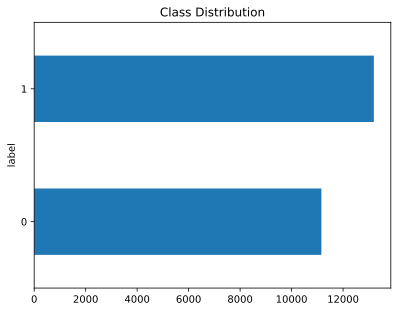

In [17]:
df['label'].value_counts(ascending=True).plot.barh()
plt.title('Class Distribution')
plt.show()

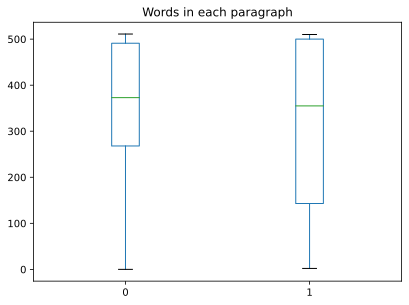

In [18]:
df['Words in each paragraph'] = df['text'].str.split().apply(len)
df.boxplot('Words in each paragraph', by='label', grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.show()

In [19]:
dataset.reset_format()

# Using Distilbert model

I will use this model " https://huggingface.co/distilbert/distilbert-base-uncased "

In [21]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [22]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [23]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [24]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [25]:
tokenizer.vocab_size

30522

In [26]:
tokenizer.model_max_length

512

In [27]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

# Tokenizing the dataset

In [28]:
def tokenize(batch):
    combined_texts = [f"{title} {text}" for title, text in zip(batch["title"], batch["text"])]
    return tokenizer(combined_texts, padding=True, truncation=True)

In [29]:
print(tokenize(dataset["train"][:2]))

{'input_ids': [[101, 1520, 5003, 13098, 1521, 2265, 2880, 9130, 8466, 1042, 1008, 23616, 2098, 2039, 14408, 3258, 2006, 4113, 2008, 3504, 2066, 6945, 8096, 1006, 3746, 1007, 5003, 13098, 2003, 3383, 2028, 1997, 1996, 11669, 10458, 3065, 2006, 2547, 2651, 1012, 2009, 1055, 2157, 1999, 2240, 2007, 1996, 7777, 1997, 1996, 9535, 3334, 11669, 2008, 2003, 6128, 17481, 1010, 1998, 1996, 2755, 2008, 2216, 3065, 2024, 2145, 2006, 1996, 2250, 2007, 1996, 4485, 2027, 2250, 2428, 2003, 1037, 6517, 9025, 2000, 2054, 4841, 2424, 2000, 2022, 14036, 1012, 2174, 1010, 5003, 13098, 2428, 4625, 1996, 2240, 2007, 1037, 9130, 2695, 4953, 2028, 1997, 2037, 4113, 1055, 3311, 2007, 1037, 25047, 1010, 19424, 14408, 3258, 2006, 9857, 3944, 1012, 2045, 2001, 1037, 2402, 2450, 2006, 2045, 2725, 2028, 1997, 2037, 4178, 4953, 1996, 6986, 11795, 3012, 1997, 2014, 2775, 1012, 2174, 1010, 2006, 1996, 3931, 1010, 1996, 2265, 6866, 2019, 3746, 1997, 1996, 2450, 1010, 2040, 6433, 2000, 4562, 1037, 8478, 14062, 2000, 5205

In [30]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

In [31]:
print(dataset_encoded["train"].column_names)

['Unnamed: 0', 'title', 'text', 'label', 'input_ids', 'attention_mask']


# Finetuning the DistilBert model for classification task

## Loading the pretrained model

In [32]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification

In [33]:
num_labels = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = (AutoModelForSequenceClassification
 .from_pretrained("distilbert-base-uncased", num_labels=num_labels)
 .to(device))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
device

device(type='cuda')

## Defining the performance metrics

In [35]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
 labels = pred.label_ids
 preds = pred.predictions.argmax(-1)
 f1 = f1_score(labels, preds, average="weighted")
 acc = accuracy_score(labels, preds)
 return {"accuracy": acc, "f1": f1}

In [36]:
from huggingface_hub import notebook_login
notebook_login()

In [20]:
!pip install transformers
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [56]:
batch_size = 32
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = "distilbert-base-uncased-finetuned-fake-news"
training_args = TrainingArguments(output_dir=model_name,
num_train_epochs=2,
learning_rate=2e-5,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
weight_decay=0.01,
evaluation_strategy="epoch",
disable_tqdm=False,
logging_steps=logging_steps,
push_to_hub=True,
log_level="error")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
from transformers import Trainer, TrainingArguments

In [57]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
 compute_metrics=compute_metrics,
 train_dataset=dataset_encoded["train"],
 eval_dataset=dataset_encoded["validation"],
 tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.030000,0.036399,0.988050,0.988053
2,0.012100,0.040254,0.989159,0.989158


TrainOutput(global_step=1524, training_loss=0.021037509272010535, metrics={'train_runtime': 2617.5998, 'train_samples_per_second': 18.607, 'train_steps_per_second': 0.582, 'total_flos': 6451957118939136.0, 'train_loss': 0.021037509272010535, 'epoch': 2.0})

In [58]:
preds_output = trainer.predict(dataset_encoded["validation"])

In [59]:
preds_output.metrics

{'test_loss': 0.04025420546531677,
 'test_accuracy': 0.9891585561167919,
 'test_f1': 0.9891576559862606,
 'test_runtime': 136.061,
 'test_samples_per_second': 59.657,
 'test_steps_per_second': 1.867}

In [62]:
from torch.nn.functional import cross_entropy
def forward_pass_with_label(batch):
 # Place all input tensors on the same device as the model
 inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
 with torch.no_grad():
  output = model(**inputs)
  pred_label = torch.argmax(output.logits, axis=-1)
  loss = cross_entropy(output.logits, batch["label"].to(device),
  reduction="none")
 # Place outputs on CPU for compatibility with other dataset columns
 return {"loss": loss.cpu().numpy(),
 "predicted_label": pred_label.cpu().numpy()}

In [63]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
 columns=["input_ids", "attention_mask", "label"])
# Compute loss values
dataset_encoded["validation"] = dataset_encoded["validation"].map(
 forward_pass_with_label, batched=True, batch_size=16)


Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

In [67]:
import pandas as pd

In [70]:
print(dataset_encoded["train"].features["label"])


Value(dtype='int64', id=None)


In [73]:
dataset_encoded.set_format(type="pandas")
cols = ["title", "text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["validation"][:][cols]

In [74]:
df_test.sort_values("loss", ascending=False).head(10)

,title,text,label,predicted_label,loss
3118,trump advocates the american peoples control o...,brilliant,0,1,8.707501
2732,fbi folds comey announces no criminal charges ...,trumps grandfather was a pimp and tax evader h...,0,1,8.389843
6360,uk economy grows in three months after brexit...,christians martyred by isis in addition at lea...,0,1,8.309413
3738,boom math shows trump would have beaten obama ...,copyright percentfedupcom in association with ...,1,0,8.249882
1093,trump presidency creates mountains of salt fro...,leave a reply chelsea clintons wedding was pai...,1,0,8.072529
7353,things america can learn from hungarys resista...,leave a reply doreen virtue its a powerful and...,1,0,7.818609
4506,trump supporter whose brutal beating by black ...,go to article filmmaker ami horowitz takes to ...,1,0,6.756285
1604,not kidding colleges give students safe spaces...,email for republican politicians like ohio gov...,1,0,6.697127
3023,florida voters approve medical marijuana rejec...,on october pm one thing that has continuously ...,0,1,6.558954
5936,dr duke and pastor dankof on trumps america fi...,september new homes sales rise back to level b...,1,0,6.391397


In [75]:
df_test.sort_values("loss", ascending=True).head(10)

,title,text,label,predicted_label,loss
4866,Moscow has never supported complete embargo on...,MOSCOW (Reuters) - Russian Deputy Foreign Mini...,1,1,0.000023
5873,Democratic congressman Schiff says Trump-Putin...,WASHINGTON (Reuters) - The top Democrat on the...,1,1,0.000023
4025,We don't know what Trump has decided on Paris ...,BERLIN (Reuters) - The German government does ...,1,1,0.000023
717,Geneva process is the only appropriate format ...,PARIS (Reuters) - France said on Thursday that...,1,1,0.000023
6432,"Trump speaks with leaders of Saudi Arabia, UAE...",WASHINGTON (Reuters) - U.S. President Donald T...,1,1,0.000023
740,"Trump, UK's May agree that China must do more ...",LONDON (Reuters) - U.S. President Donald Trump...,1,1,0.000024
3105,EU's top diplomat defends Iran deal after Trum...,BRUSSELS (Reuters) - The United States cannot ...,1,1,0.000024
4811,Tehran says no link between Britain's debt to ...,ANKARA (Reuters) - Iran rejected as wrong some...,1,1,0.000024
4256,"Lawmakers briefed on reported DNC hack, seek i...",WASHINGTON (Reuters) - The top Democrat on the...,1,1,0.000024
3809,"Arab states blacklist Islamist groups, individ...",DUBAI (Reuters) - The four Arab countries boyc...,1,1,0.000024


## Pushing the model to HuggingFace

In [76]:
trainer.push_to_hub(commit_message="Model is ready!")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

events.out.tfevents.1716340549.5a627fbf784d.1262.9:   0%|          | 0.00/6.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/vuravura/distilbert-base-uncased-finetuned-fake-news/commit/0757d76365eb80dd59c688e670272f3db3ff68c7', commit_message='Model is ready!', commit_description='', oid='0757d76365eb80dd59c688e670272f3db3ff68c7', pr_url=None, pr_revision=None, pr_num=None)